<h2>Analyzing New York City Bike Data in Real Time</h2>


<p>Objective: Find out how active New York City's bike share program is in real time. First, calculate the number of bikes available at dock stations for every minute for an hour across all of New York City. Then, find the most active station -- the station that has the most change (number of bikes coming in and out of station docks) in the hour.</p>

<p>Data Source: http://www.citibikenyc.com/stations/json/</p>

<p>More about the Citibike in NYC: https://www.citibikenyc.com/<p>

<h3>Download the Data</h3>

In [2]:
import requests 
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as lite
import time
import datetime
import collections
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
from dateutil.parser import parse 

%matplotlib inline

In [2]:
r = requests.get("http://www.citibikenyc.com/stations/json")
r.json()

{u'executionTime': u'2015-10-05 01:29:12 AM',
 u'stationBeanList': [{u'altitude': u'',
   u'availableBikes': 22,
   u'availableDocks': 17,
   u'city': u'',
   u'id': 72,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-10-05 01:28:54 AM',
   u'latitude': 40.76727216,
   u'location': u'',
   u'longitude': -73.99392888,
   u'postalCode': u'',
   u'stAddress1': u'W 52 St & 11 Ave',
   u'stAddress2': u'',
   u'stationName': u'W 52 St & 11 Ave',
   u'statusKey': 1,
   u'statusValue': u'In Service',
   u'testStation': False,
   u'totalDocks': 39},
  {u'altitude': u'',
   u'availableBikes': 3,
   u'availableDocks': 29,
   u'city': u'',
   u'id': 79,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-10-05 01:25:35 AM',
   u'latitude': 40.71911552,
   u'location': u'',
   u'longitude': -74.00666661,
   u'postalCode': u'',
   u'stAddress1': u'Franklin St & W Broadway',
   u'stAddress2': u'',
   u'stationName': u'Franklin St & W Broadway',
   u'statusKey': 1,
   u'statusValue': u'I

In [3]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [4]:
# number of docks

len(r.json()['stationBeanList'])

508

In [5]:
# unique list of keys for each station listing

key_list = [] 
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)
print(key_list)

[u'availableDocks', u'totalDocks', u'city', u'altitude', u'stAddress2', u'longitude', u'lastCommunicationTime', u'postalCode', u'statusValue', u'testStation', u'stAddress1', u'stationName', u'landMark', u'latitude', u'statusKey', u'availableBikes', u'id', u'location']


In [6]:
df = json_normalize(r.json()['stationBeanList'])
print(df)

    altitude  availableBikes  availableDocks city    id landMark  \
0                         22              17         72            
1                          3              29         79            
2                         13              14         82            
3                          7              53         83            
4                         23              14        116            
5                         14               5        119            
6                          5              14        120            
7                         29               1        127            
8                          0              29        128            
9                         28              18        137            
10                        11              13        143            
11                         3              16        144            
12                         7              32        146            
13                         3              30    

<h3>Quick data exploration</h3>

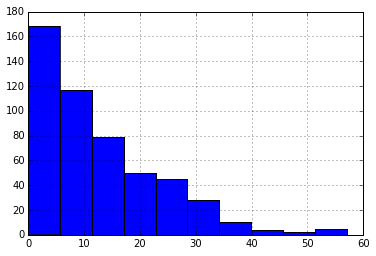

In [7]:
# available bikes

df['availableBikes'].hist()
plt.show()

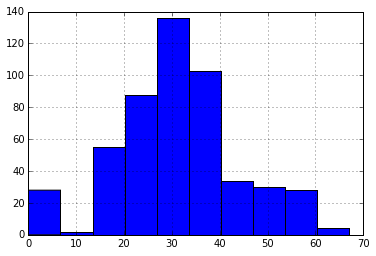

In [8]:
# total docks

df['totalDocks'].hist()
plt.show()

In [9]:
# mean of stations that are active 

condition = (df["statusValue"] == "In Service")
df[condition]["totalDocks"].mean()

32.76955602536998

In [10]:
# median of stations that are active; alternative syntax to above 

df[df["statusValue"] == "In Service"]["totalDocks"].median()

31.0

<h3>Store Data into SQLite DB</h3>

In [11]:
# db connection 

con = lite.connect("citi_bike.db")
cur = con.cursor()

In [12]:
# create table for citibike reference

insert_reference = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"

def create_reference():
    with con: 
        cur.execute("CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT)")

        for station in r.json()["stationBeanList"]: 
            cur.execute(insert_reference, (station["id"],station["totalDocks"],station["city"],station["altitude"],station["stAddress2"],station["longitude"],station["postalCode"],station["testStation"],station["stAddress1"],station["stationName"],station["landMark"],station["latitude"],station["location"]))

create_reference() 

In [ ]:
# create table for available bikes; update data every minute for an hour 
# test out for every 5 minutes

station_ids = df["id"].tolist()
station_ids = ["_" + str(x) + " INT" for x in station_ids]

def create_avail_bikes(): 
    with con: 
        cur.execute("CREATE TABLE available_bikes ( execution_time INT, " + ", ".join(station_ids) + ");")
        
        for i in range(60): 
            r = requests.get("http://www.citibikenyc.com/stations/json")
            exec_time = parse(r.json()["executionTime"])  

            cur.execute("INSERT INTO available_bikes(execution_time) VALUES (?)", (exec_time.strftime("%s"),))
            con.commit()

            id_bikes = collections.defaultdict(int)
            for station in r.json()["stationBeanList"]: 
                id_bikes[station["id"]] = station["availableBikes"]

            for k,v in id_bikes.iteritems(): 
                cur.execute("UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " WHERE execution_time = " + exec_time.strftime('%s') + ";")
            con.commit()

            # pause the program for 60 seconds  
            time.sleep(60)
        
create_avail_bikes()


In [ ]:
# quick check to see data in data frame 

df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time",con,index_col='execution_time')
df

<h3> Analyze the results</h3>

In [ ]:
# calculate the change in available bikes between every minute for each station
# create a dictionary with the station id and the change in available bikes

hour_change = collections.defaultdict(int)

def calc_change(): 
    for col in df.columns:
        station_vals = df[col].tolist()
        station_id = col[1:] #trim the "_"
        station_change = 0

        # print "station id {} and number of bikes {}".format(station_id, station_vals)

        # enumerate to get index number and number of stations
        for k,v in enumerate(station_vals):   
            if k < len(station_vals) - 1:
                station_change += abs(station_vals[k] - station_vals[k+1])
        hour_change[int(station_id)] = station_change  
        
calc_change()

In [ ]:
# get the station ID with the largest change in available bikes 

def max_key(d):
    v = list(d.values())
    k = list(d.keys())  
    
    return k[v.index(max(v))]

max_station = max_key(hour_change)


In [ ]:
# get the largest change in available bikes 

def max_avail_bikes(d): 
    v = list(d.values())
    k = list(d.keys()) 
        
    return max(v)
    
max_bikes = max_avail_bikes(hour_change)
    

In [ ]:
# query sqlite for reference information

cur.execute("SELECT id, stationname, latitude, longitude FROM citibike_reference WHERE id = ?", (max_station,))
data = cur.fetchone()

print "The most active station is station number {} at {} with latitude: {} and longitude: {}".format(data[0], data[1], data[2], data[3])
print "With " + str(max_bikes) + " bicycles coming and going in the hour between " + datetime.datetime.fromtimestamp(int(df.index[0])).strftime('%Y-%m-%dT%H:%M:%S') + " and " + datetime.datetime.fromtimestamp(int(df.index[-1])).strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
# simple bar chart

x = hour_change.keys()
y = hour_change.values()
plt.xlabel('Station ID')
plt.ylabel('Num of Bikes Entering/Exiting Station')
plt.bar(x, y)
plt.show()